In [19]:
import numpy as np
import basix.ufl
import ufl
import dolfinx
from mpi4py import MPI
import pyvista
import math

def diameter_at_x(geo, x):

    if x==0:
        return geo[0][1]

    for i in range(len(geo)):
        if x<geo[i][0]:
            break

    x1=geo[i-1][0]
    y1=geo[i-1][1]
    x2=geo[i][0]
    y2=geo[i][1]

    ydiff=(y2-y1)/2
    xdiff=(x2-x1)

    winkel=math.atan(ydiff/xdiff)
    y=math.tan(winkel)*(x-x1)*2+y1
    return y

def segmentize_geo(geo, resolution):
    xs = [g[0] for g in geo]
    for x in range(0, xs[-1], resolution):
        if x not in xs:
            xs.append(x)
    xs = sorted(xs)

    new_geo = []
    for x in xs:
        y = diameter_at_x(geo, x)
        new_geo.append([x,y])

    return new_geo

geo = [[0,32], [800,32], [900,38], [970,42], [1050, 40], [1180, 48], [1350, 60], [1390, 68], [1500, 72]]
geo = segmentize_geo(geo, 10)


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


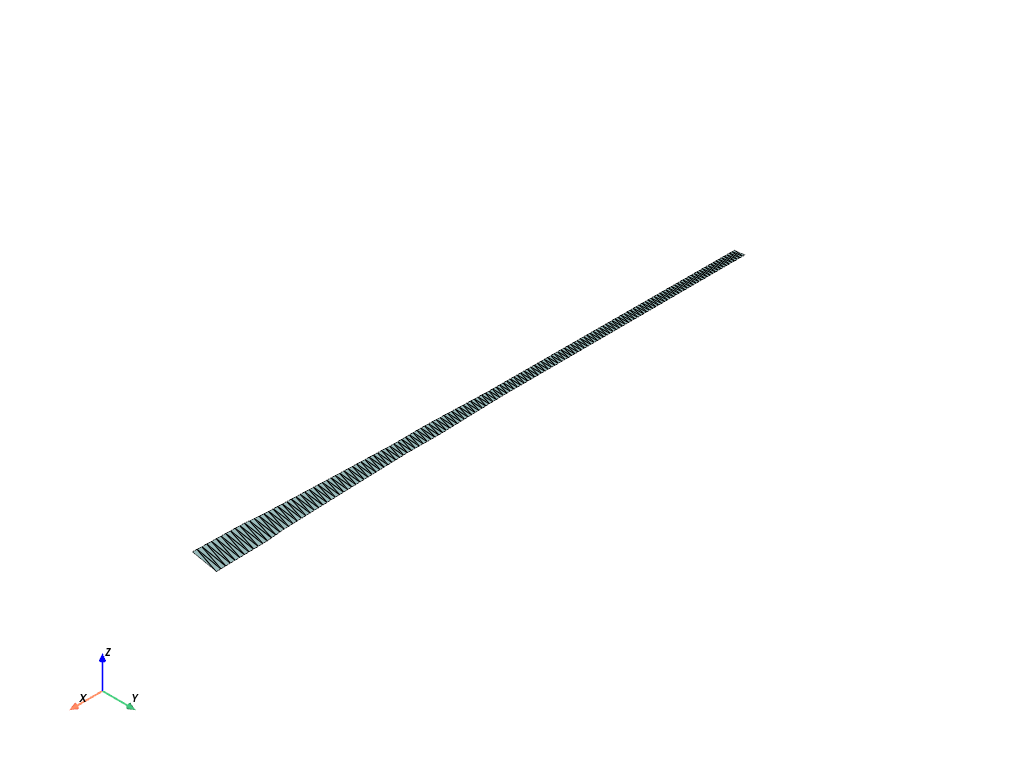

In [20]:
tri_points = []
triangles = []

for g in geo:
    p1 = g.copy()
    p1[0] /= 1000
    p1[1]/=1000*2
    p2 = g.copy()
    p2[0] /= 1000
    p2[1]/=-1000*2

    tri_points.append(p1)
    tri_points.append(p2)

    i = len(tri_points)
    if len(tri_points)<3:
        continue

    triangles.append([i-4, i-3, i-2])
    triangles.append([i-3, i-2, i-1])

ufl_tri = ufl.Mesh(basix.ufl.element("Lagrange", "triangle", 1, shape=(2,)))
tri_mesh = dolfinx.mesh.create_mesh(MPI.COMM_WORLD, triangles, tri_points, ufl_tri)
_tri = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(tri_mesh))

pyvista.start_xvfb(1)
plotter = pyvista.Plotter(shape=(1, 1))
plotter.subplot(0, 0)
plotter.show_axes()
plotter.add_mesh(_tri, show_edges=True)
plotter.show()

In [6]:
V = dolfinx.fem.functionspace(tri_mesh, ("Lagrange", 1))

# Discrete frequency range
freq = np.arange(10, 1000, 5)  # Hz

# Air parameters
rho0 = 1.225  # kg/m^3
c = 340  # m/s


In [7]:
# Impedance calculation
def delany_bazley_layer(f, rho0, c, sigma):
    X = rho0 * f / sigma
    Zc = rho0 * c * (1 + 0.0571 * X**-0.754 - 1j * 0.087 * X**-0.732)
    kc = 2 * np.pi * f / c * (1 + 0.0978 * (X**-0.700) - 1j * 0.189 * (X**-0.595))
    Z_s = -1j * Zc * (1 / np.tan(kc * d))
    return Z_s


sigma = 1.5e4
d = 0.01
Z_s = delany_bazley_layer(freq, rho0, c, sigma)


In [14]:
from mpi4py import MPI
from dolfinx import (
    fem,
    io,
    default_scalar_type,
    geometry,
    __version__ as dolfinx_version,
)

omega = fem.Constant(tri_mesh, default_scalar_type(0))
k = fem.Constant(tri_mesh, default_scalar_type(0))
Z = fem.Constant(tri_mesh, default_scalar_type(0))
v_n = 1e-5


In [18]:
ds = ufl.Measure("ds", domain=tri_mesh)

p = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = (
    ufl.inner(ufl.grad(p), ufl.grad(v)) * ufl.dx
    + 1j * rho0 * omega / Z * ufl.inner(p, v) * ds(Z_bc_tag)
    - k**2 * ufl.inner(p, v) * ufl.dx
)
L = -1j * omega * rho0 * ufl.inner(v_n, v) * ds(v_bc_tag)


NameError: name 'Z_bc_tag' is not defined

In [33]:
## Define monopole source

mesh = tri_mesh
def delta_dirac(src, rec):
    return np.any(np.isclose(src,rec))

## Define FEM problem
V = dolfinx.fem.functionspace(mesh, ("CG", 1))
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = dolfinx.fem.Function(V)

rho0 = 1.225  # kg/m^3
c = 340  # m/s

f.interpolate(lambda x: [1j*rho_0*omega*Q*delta_dirac(src, item) for item in np.transpose(x)])

a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx - k**2 * ufl.inner(u, v) * ufl.dx
L = ufl.inner(f, v) * ufl.dx

# Compute solution
uh = dolfinx.fem.Function(V)
uh.name = "u"
problem = dolfinx.fem.LinearProblem(a, L, u=uh)
problem.solve()


NameError: name 'rho_0' is not defined

In [19]:
from mpi4py import MPI
from dolfinx import (
    fem,
    io,
    default_scalar_type,
    geometry,
    __version__ as dolfinx_version,
)
from dolfinx.fem.petsc import LinearProblem
import ufl
import numpy as np
import numpy.typing as npt
from packaging.version import Version

domain = tri_mesh
V = fem.functionspace(domain, ("Lagrange", 1))

# Discrete frequency range
freq = np.arange(10, 1000, 5)  # Hz

# Air parameters
rho0 = 1.225  # kg/m^3
c = 340  # m/s

# Impedance calculation
def delany_bazley_layer(f, rho0, c, sigma):
    X = rho0 * f / sigma
    Zc = rho0 * c * (1 + 0.0571 * X**-0.754 - 1j * 0.087 * X**-0.732)
    kc = 2 * np.pi * f / c * (1 + 0.0978 * (X**-0.700) - 1j * 0.189 * (X**-0.595))
    Z_s = -1j * Zc * (1 / np.tan(kc * d))
    return Z_s


sigma = 1.5e4
d = 0.01
Z_s = delany_bazley_layer(freq, rho0, c, sigma)

omega = fem.Constant(domain, default_scalar_type(0))
k = fem.Constant(domain, default_scalar_type(0))
Z = fem.Constant(domain, default_scalar_type(0))
v_n = 1e-5

ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)


NameError: name 'facet_tags' is not defined

In [21]:
domain.facet_tags

AttributeError: 'Mesh' object has no attribute 'facet_tags'